# Analysis of $Mo_{1-x}Re_xS_2$ images

**Extract statistically significant information about effective interactions between Mo and Re atoms**

## Table of Contents

* [1. Images](#1.-Images)
* [2. Target and random histograms](#2.-Target-and-random-histograms)
* [3. Statistical distance profiles](#3.-Statistical-distance-profiles)
* [4. Statistical significance analysis](#4.-Statistical-significance-analysis)
* [5. Conclusions](#5.-Conclusions)

**Notebook setup**

In [18]:
%matplotlib inline

import os
import sys
import copy
import pickle
from collections import Counter
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import norm, chi2
from scipy.optimize import fmin
import pyUSID
from skimage.color import rgb2gray
from skimage.io import imread

from subprocess import Popen, PIPE
import multiprocessing as mp

import matplotlib.image as mpimg
from skimage import color
from scipy import fftpack
from scipy import ndimage
from pysptools.eea import nfindr
import pysptools.abundance_maps as amp
#import eea
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import decomposition
from sklearn.decomposition import NMF

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt
from statmechlib.forcefields import sd2

sys.path.append('../src/utils')
from utils import *

In [21]:
np.random.seed(42)
data_dir = '../data/raw'
sim_dir = '../src/code'

## 1. Images

Extract Mo and Re positions for each image

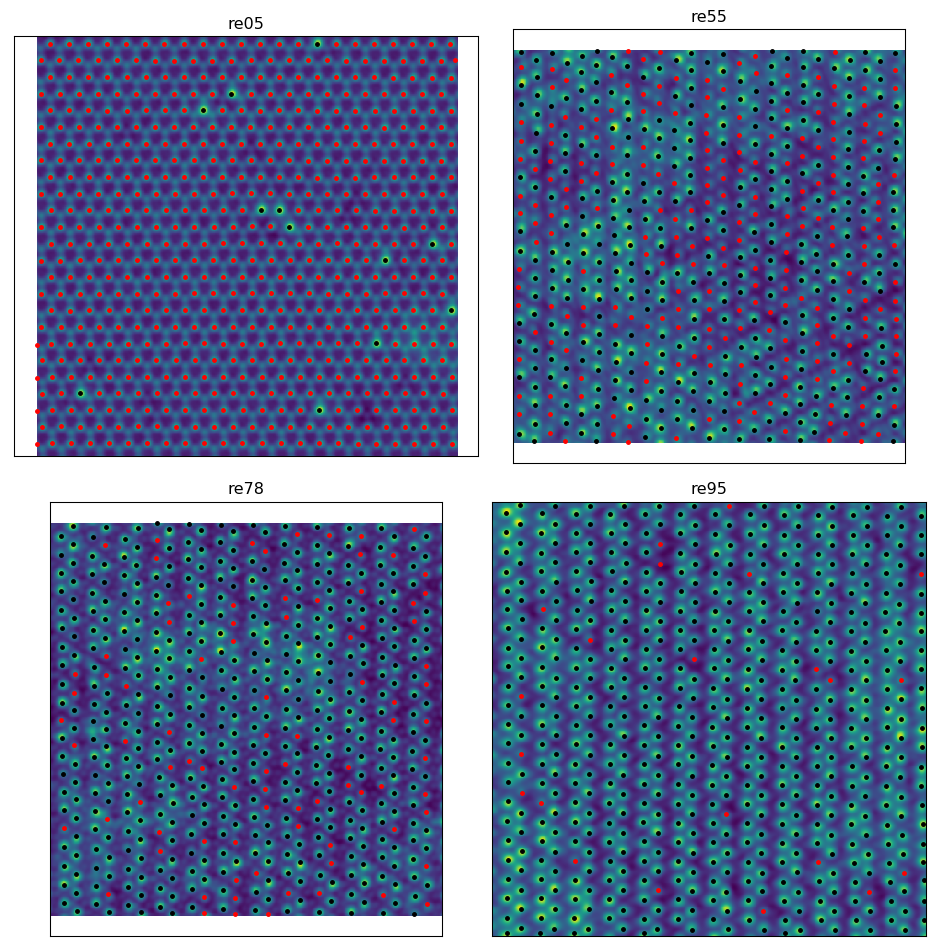

In [22]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file name roots

# Separate atoms to Mo and Re based on image-specific intensity threshold
intensity_thresh = [0.80, 0.45, 0.45, 0.45]  # intensity thresholds for each image
atom_pos, atom_ids, intensities = get_atom_positions(data_dir, names, intensity_thresh)

show_images(names, atom_pos, atom_ids, intensities)

In [24]:
intensities[0].shape

(662, 663)

In [25]:
#%%Functions%%
def LoadFile(full_path):
    #Loads the file from the path full_path
    #Returns the image after conversion to grayscale

    imgsrc = color.rgb2gray(mpimg.imread(full_path));
    return imgsrc

def ApplyHamming(imgsrc):
    #Applies a Hamming window to the input imgsec, returns the window after filter applied.
    bw2d = np.outer(np.hamming(window_size), np.ones(window_size))
    bw2d = np.sqrt(bw2d * bw2d.T) 
    imgsrc *= bw2d
    return imgsrc
    
def MakeWindow(imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

def GenerateXYPos(window_size, window_step, image_width):   
    #Generates the (x,y) pairs given the window size, window step and image width (=height)
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
    num_steps = len(xpos_vec)       
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))
              
    return pos_mat

def zoom_interpol(FFT_image):   
    #Accepts an image, returns zoomed image
    zoom_size = (FFT_image.shape[0]/FFT_zoom_factor)/2
    if np.mod(FFT_image.shape[0]/FFT_zoom_factor,2)==0:
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2 + zoom_size), 
                             int(window_size/2 - zoom_size):int(window_size/2 +zoom_size)]
    else:                    
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2+1 + zoom_size), 
                             int(window_size/2 - zoom_size):int(window_size/2 + 1+zoom_size)]
    
    return ndimage.zoom(F2_zoomed,interpol_factor)
    
def plot_FFT_window(FFT_final, option):   #1 for normal, option is str defining plot type
    plt.figure()
    plt.cla()

    if option =='log':
        plt.imshow(np.log(abs(FFT_final)), interpolation = 'none')    
        
    elif option =='sqrt':
        plt.imshow(np.sqrt(abs(FFT_final)), interpolation = 'none')    

    else:
        plt.imshow(abs(FFT_final), interpolation = 'none')    
        
def Do_Sliding_FFT():
    #Carries out the FFT
    FFT_mat4 = np.zeros(shape = (len(pos_mat), 
                                 int(window_size*interpol_factor/FFT_zoom_factor), 
                                 int(window_size*interpol_factor/FFT_zoom_factor)))

    for i in np.arange(0,len(pos_mat)):
        
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1]) #Generate the window on which FFT is performed
                               
        #Pass the x and y positions of the top-left corner of the FFT window
        #These positions are located in pos_mat
        
        if hamming_filter ==1: #Apply filter if requested
            img_window_filtered = ApplyHamming(np.copy(img_window))
        else:
            img_window_filtered = (np.copy(img_window))
        
        # Take the fourier transform of the image.
        F1 = fftpack.fft2((img_window_filtered)) 
        
        # Now shift so that low spatial frequencies are in the center.
        F2 = (fftpack.fftshift((F1)))
       
        final_FFT = zoom_interpol(np.abs(F2))
        
        FFT_mat4[i,:,:,] = final_FFT

    return FFT_mat4

    
def analyze_endmembers(FFT_mat, num_comp):
    #Determines endmembers given the 3D FFT matrix.
    #Analyzes results by NFINDR
    #Plots the results and saves to .png files


    #Find endmembers and abundance maps
    ne = num_comp #Number of endmembers
    
    q = FFT_mat.shape
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.abs(data_mat3)
    
    nnls = amp.FCLS()
    a1 = nfindr.NFINDR(data_mat3, ne) #Find endmembers
    endmembers = a1[0]
    
    data_mat3 = data_mat3.reshape((a,b, c*d))
    amap = nnls.map(data_mat3, endmembers) #Find abundances
    
    #Do plotting
    fig301, axes301 = plt.subplots(2, 3, figsize=(10, 10))
    
    indices = np.arange(0,ne)
    endmembers = endmembers.reshape(ne, c, d) 

    for ax, index in zip(axes301.flat, indices):
        im = ax.imshow(np.sqrt(endmembers[index,:,:]), interpolation = 'none' )
        ax.set_title('Endmember: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08) #space for colorbar
        plt.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off')                
        plt.tick_params(axis='y', which='both', bottom='off',top='off',labelbottom='off')
        plt.colorbar(im, cax = cax)
        plt.tight_layout()
            
        
    fig302, axes302 = plt.subplots(2, 3, figsize=(10, 10))
    
    for ax, index in zip(axes302.flat, indices):
        im = ax.imshow(np.flipud(np.rot90(amap[:,:,index])), interpolation = 'none')
        ax.set_title('Abundance: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08) #space for colorbar
        plt.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off')                
        plt.tick_params(axis='y', which='both', bottom='off',top='off',labelbottom='off')            
        plt.colorbar(im, cax = cax)
        plt.tight_layout()

    fig303, axes303 = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, index in zip(axes303.flat, indices):
        amap_endm = np.copy(amap[:,:,index])                            
        amap_full_sum = np.sum(amap[:,:,0:],2)
        amap_error = amap_endm - amap_full_sum
        im = ax.imshow(np.flipud(np.rot90(amap_error)), interpolation = 'none')
        ax.set_title('Error: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08) #space for colorbar                 
        plt.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off')                
        plt.tick_params(axis='y', which='both', bottom='off',top='off',labelbottom='off')                                 
        plt.colorbar(im, cax = cax)            
        plt.tight_layout()                
        
    return endmembers, amap

def do_PCA(FFT_mat):
    #Find endmembers and abundance maps  
    q = FFT_mat.shape
   
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.real(data_mat3)
    
    U, S, V = np.linalg.svd(data_mat3, full_matrices = False, compute_uv = True)
    
    
    e_vecs = S*V.T
    e_vecs = e_vecs.T
    
    e_vecs = e_vecs.reshape(a*b, c, d)
    e_vals = U.reshape((a,b, a*b))
    
    ##Plot PCA Results
    #Plot eigenvectors
    fig201, axes201 = plt.subplots(3, 3, figsize=(12, 12))
    fig201.subplots_adjust(hspace=0.3, wspace=0.3)
    fig201.canvas.set_window_title("PCA Components")
    
    indices = np.arange(0,9)
    
    for ax, index in zip(axes201.flat, indices):
        ax.imshow((e_vecs[index,:,:]))
        ax.set_title('PCA Component: %d' %(index+1))
        
    plt.show()
    #Now Plot eigenvalues
    fig202, axes202 = plt.subplots(3, 3, figsize=(12, 12))
    fig202.subplots_adjust(hspace=0.4, wspace=0.4)
    fig202.canvas.set_window_title("PCA Loadings")
    
    for ax, index in zip(axes202.flat, indices):
           
        im = ax.imshow(np.flipud(np.rot90(e_vals[:,:, index])), interpolation = 'none')
        ax.set_title('Loading: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05) #space for colorbar
        plt.colorbar(im, cax = cax)
        
    plt.show()    
    
    fig203 = plt.figure()
    axes203 = fig203.add_axes([0.1, 0.1, .8, .8]) # left, bottom, width, height (range 0 to 1)
    axes203.semilogy(S, 'b')
    axes203.set_xlabel('Principal Component')
    axes203.set_ylabel('Eigenvalues Squared')
    axes203.set_title('Scree Plot')
    fig203.canvas.set_window_title("Scree plot")
    
    return e_vecs, e_vals
                
def do_ICA(FFT_mat, num_comp):
    #Find components  
    q = FFT_mat.shape
   
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.real(data_mat3)
    
    ica = decomposition.FastICA(n_components=num_comp)
    rec_ica = ica.fit_transform(data_mat3) # do the ICA
    
    ica_comp = ica.components_      # get the components
    
    rec_ica = rec_ica.reshape(a,b,-1)  #mixing coefficeints
    ica_comp = ica_comp.reshape(-1,c,d) 
       
    ##Plot ICA Results
    #Plot eigenvectors
    if num_comp <5:
        fig401, axes401 = plt.subplots(2, 2, figsize=(12, 12))
        fig402, axes402 = plt.subplots(2, 2, figsize=(12, 12))
    
    else:
        fig401, axes401 = plt.subplots(3, 3, figsize=(12, 12))    
        fig402, axes402 = plt.subplots(3, 3, figsize=(12, 12))
        
    fig401.subplots_adjust(hspace=0.3, wspace=0.3)
    fig401.canvas.set_window_title("ICA Components")
    
    indices = np.arange(0,num_comp)
    
    for ax, index in zip(axes401.flat, indices):
        ax.imshow(ica_comp[index,:])
        ax.set_title('ICA Component: %d' %(index+1))
        
    plt.show()
    
    #Now Plot mixing maps
    fig402.subplots_adjust(hspace=0.4, wspace=0.4)
    fig402.canvas.set_window_title("ICA Mixing Coefficients")
    cp = plt.cm.jet
    
    for ax, index in zip(axes402.flat, indices):
           
        im = ax.imshow(rec_ica[:,:,index], cmap = cp, interpolation = 'none')
        divider = make_axes_locatable(ax)
        # Append axes to the right of ax3, with 10% width of ax
        cax = divider.append_axes("right", size="10%", pad=0.05)
        
        plt.colorbar(im, cax = cax, format="%.2f")
        ax.set_title('Mixing: %d' %(index+1))
       
    plt.show() 

    return ica_comp, rec_ica
 

def do_NMF(FFT_mat, num_comp):
    #Find components  
    q = FFT_mat.shape
   
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.abs(data_mat3)
    
    model = NMF(n_components=num_comp, init='random', random_state=0)
    nmf_amap = model.fit_transform(data_mat3)
    nmf_comp = model.components_
    nmf_comp = nmf_comp.reshape((num_comp,c,d))                       
    
    data_mat3 = data_mat3.reshape((a,b, c*d))
    
    #Find abundances
    nmf_amap = nmf_amap.reshape(a,b,num_comp)
    #fcls = amp.NNLS() #For abundance calculation
    #nmf_amap = fcls.map(data_mat3, nmf_comp.reshape(num_comp, c*d)) #Find abundances
        
    
    ##Plot NMF Results
    #Plot components
    if num_comp <5:
        fig501, axes501 = plt.subplots(2, 2, figsize=(12, 12))
        fig502, axes502 = plt.subplots(2, 2, figsize=(12, 12))
    elif num_comp==6:
        fig501, axes501 = plt.subplots(2, 3, figsize=(12, 12))
        fig502, axes502 = plt.subplots(2, 3, figsize=(12, 12))
    else:
        fig501, axes501 = plt.subplots(3, 3, figsize=(12, 12))    
        fig502, axes502 = plt.subplots(3, 3, figsize=(12, 12))
        
    fig501.subplots_adjust(hspace=0.3, wspace=0.3)
    fig501.canvas.set_window_title("NMF Components")
    
    indices = np.arange(0,num_comp)
    
    for ax, index in zip(axes501.flat, indices):
        ax.imshow(nmf_comp[index,:])
        ax.set_title('NMF Component: %d' %(index+1))
        
    
    
    #Now Plot mixing maps
    fig502.subplots_adjust(hspace=0.4, wspace=0.4)
    fig502.canvas.set_window_title("NMF Coefficients")
    cp = plt.cm.get_cmap('viridis')
    
    for ax, index in zip(axes502.flat, indices):
           
        im = ax.imshow(np.flipud(np.rot90(nmf_amap[:,:,index])), cmap = cp, interpolation = 'none')
        divider = make_axes_locatable(ax)
        # Append axes to the right of ax3, with 10% width of ax
        cax = divider.append_axes("right", size="10%", pad=0.05)
        
        plt.colorbar(im, cax = cax, format="%.2f")
        ax.set_title('Mixing: %d' %(index+1))
       
    
    fig501.tight_layout()
    fig502.tight_layout()
    
    return nmf_comp, nmf_amap   

In [46]:
num_of_comp = 4 #Number of endmembers for NFINDR
window_size = 128 # #x=y sizes for sliding window
window_step = 16 # #x=y sizes of each step
hamming_filter = 1 #1 for use of hamming window
FFT_zoom_factor = 2 #Zoom factor for FFT
interpol_factor = 4 #Factor for interpolation
raw_image = intensities[3]

In [47]:
pos_mat = GenerateXYPos(window_size, window_step, raw_image.shape[0]) #Generate matrix with (x,y) locations of window position


In [48]:
FFT_mat4 = Do_Sliding_FFT() #Do the Sliding FFT   
FFT_mat5 = FFT_mat4.reshape(int(np.sqrt(FFT_mat4.shape[0])),
                                    int(np.sqrt(FFT_mat4.shape[0])),                            
                                    int(window_size*interpol_factor/FFT_zoom_factor), 
                                    int(window_size*interpol_factor/FFT_zoom_factor))      

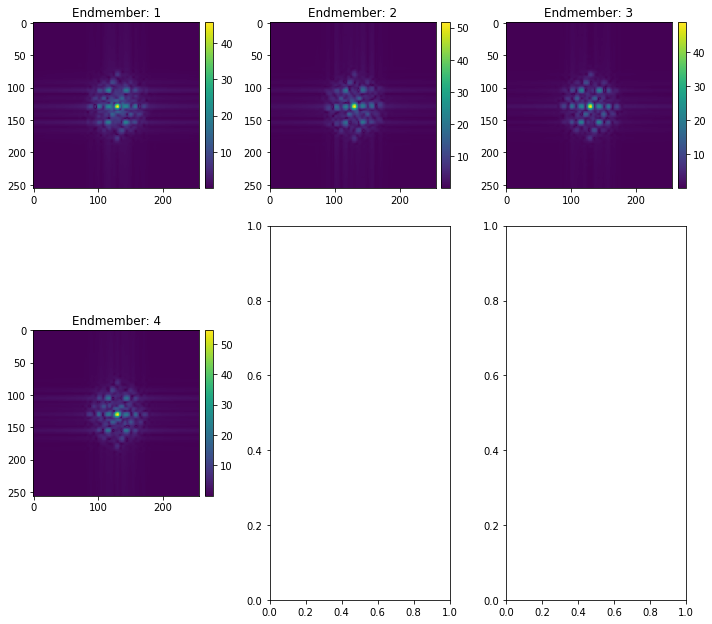

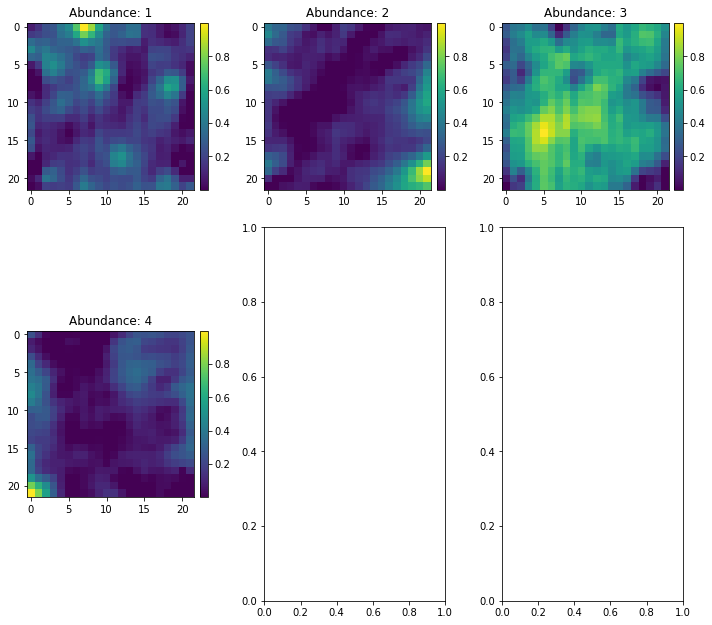

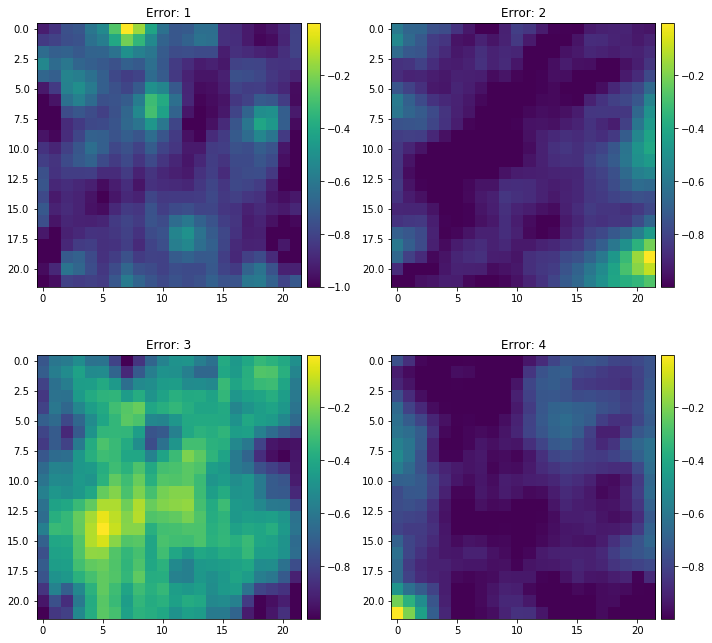

In [49]:
FFT_mat5.shape
endmembers, amap = analyze_endmembers(FFT_mat5, num_of_comp) 

In [17]:
#TODO: Adjust helper_funcs so the plots have appropriate axes, titles, etc.

border = 10 #border pixels
num_neighbors = 6 #number of NN to analyze
num_clusters = 11 #Number of kmeans clusters

threshold_val = 0.60

cropped_image = (re55 - np.min(re55)) / (np.max(re55) - np.min(re55))

raw_image = cropped_image

image_size_x = raw_image.shape[0]
image_size_y = raw_image.shape[1]

#atom_positions = np.vstack((atom_centroids_1, atom_centroids_2))

# Edge Atom Eliminator for k-means algorithm 
x_y_positions_edge_cut = edge_eliminator(raw_image, atom_positions, border_pixels=border)

all_x = x_y_positions_edge_cut[:,0]
all_y = x_y_positions_edge_cut[:,1]

nbrs = NearestNeighbors(n_neighbors=num_neighbors+1, algorithm='brute').fit(atom_positions)
distance_vec, full_index = nbrs.kneighbors(atom_positions)

nn_index = full_index[:,1:]

# rename for convenience
atom_pos_cen = x_y_positions_edge_cut;
atom_pos_all = atom_positions;
        
Mo_atoms, Mo_atom_id, dopant_atoms, dopant_atom_id = \
threshold_and_border_correction(atom_pos_all, border_pixels=border,
                                threshold_val = threshold_val, cropped_image=cropped_image);

Re55 = {'Image': re55, 'Mo_atoms': Mo_atoms, 'Re_atoms': dopant_atoms}

plt.figure(10, figsize = (10,10))
plt.imshow(raw_image)
for i in range(atom_pos_all.shape[0]):
    re_x = atom_pos_cen[i,0]
    re_y = atom_pos_cen[i,1]
    plt.scatter(re_y, re_x, s=2, c = 'b')

choices = ['Mo', 'Re']

local_cryst_results={}

for choice in choices:

    if choice=='Mo':
        dopant_atoms2 = Mo_atoms.copy()
        dopant_atoms2_id = Mo_atom_id.copy()
        print('Calculating Results for Mo atom neighborhood only')
    else:
        print('Calculating Results for Re atom neighborhood only')
        dopant_atoms2 = dopant_atoms.copy()
        dopant_atoms2_id = dopant_atom_id.copy()

    d_mat, a_mat, xd_mat, yd_mat, atom_neighbor_pos = do_NN_analysis_ind(atom_pos_all,
                                                                         dopant_atoms2, dopant_atoms2_id, nn_index, num_neighbors=num_neighbors)

    nn_type = return_neighbor_type(atom_neighbor_pos, atom_pos_all, Mo_atom_id, dopant_atom_id)
    
    # plot neighborhood point cloud and perform PCA
    do_plot_pca_results(d_mat, a_mat, xd_mat, yd_mat, raw_image, dopant_atoms2, border =0)
    
    #do kmeans of point clouds
    do_plot_kmeans_results(xd_mat, yd_mat, dopant_atoms2, cropped_image,num_clusters = num_clusters)
    
    local_cryst_results[choice] = [d_mat, a_mat, xd_mat, yd_mat, dopant_atoms2, nn_type]
    
Re55['local_crystallography'] = local_cryst_results


NameError: name 're55' is not defined

### Identify distinct local configurations and collect target histograms

In [15]:
distance_thresh = [45, 32, 30, 26]  # distance thresholds for each image
target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids, distance_thresh)

cfg_types = sorted(set([c for h in target_hist.values() for c in h]))

# symmetry number for each configuration
conf_counts, conf_dict, trans_hist = config_symmetry_numbers(cfg_types)

#trans_hist = make_transform_matrix(cfg_types, conf_dict)

# probability of each symmetrized configuration for a given Re concentration
x_re = rhenium_concentration(target_hist)

# random - null hypothesis
prob_conf = random_config_proba(names, conf_counts, x_re)

# applies uninformative multinomial (Jeffrey's) prior to deal with low-sampling-caused zero counts
target_hist_adjusted = apply_prior(names, conf_counts, cfg_types, target_hist, prob_conf)

# get estimated probability distribution of the target for model optimization
#gsv = get_probability_histogram(names, cfg_types, target_hist_adjusted)
gsv = get_probability_histogram(names, cfg_types, target_hist)

## 2. Target and random histograms

**Comparison of target (adjusted) and random (null) histograms of local configurations**

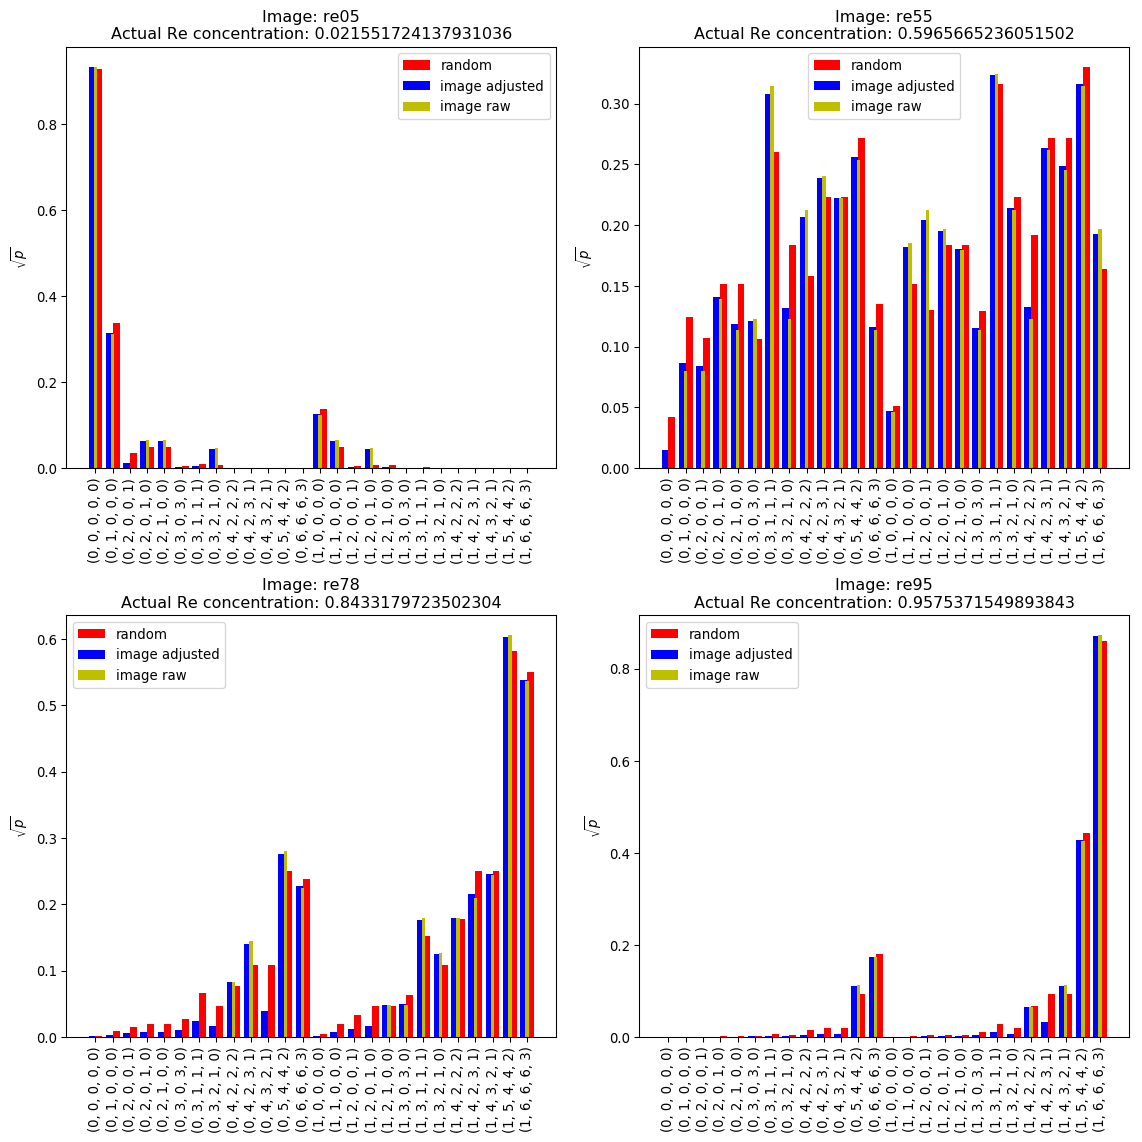

In [16]:
plot_histograms(names, num_samples, target_hist, target_hist_adjusted, prob_conf, cfg_types, x_re)

In [17]:
# define data sets for which parameters will be optimized
all_datasets = {0:tuple(names)}
all_datasets.update({i:s for i, s in enumerate(combinations(names, 3), len(all_datasets))})
all_datasets.update({i:s for i, s in enumerate(combinations(names, 2), len(all_datasets))})
all_datasets.update({i:s for i, s in enumerate(combinations(names, 1), len(all_datasets))})
#print(all_datasets)

### Read input data from refrence simulations

In [18]:
dset = all_datasets[0]
input_datax = {}

for key in ['null_', '0_m2_', '0_p2_', 'm2_0_', 'p2_0_']:

    # directory names
    dirnames = [key + s for s in dset]
    data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

    # get reference parameters
    pars_ref = read_mld(data_paths, read_modeldef)
    pars_in = np.array([pars_ref[1], pars_ref[4]])

    # read reference data
    trjs = read_outputs(dset, data_paths, read_lattice_model)
        
    # select the equilibrated part of the trajectories
    trjs = trajectory_range(trjs, imin=1000)
        
    # get histograms of symmetrized configurations
    hsv = make_reference_histograms(trjs, trans_hist)
    for key_hsv, val in hsv.items():
        #print('n_eff:', n_effective(val))
        pass

    # get statistics of lattice model energetics
    hsu = make_energy_statistics(trjs)
        
    # make targets and statistics for optimization with selected names
    targets = make_targets(gsv, num_samples)
    stats = make_stats(trjs, hsu, hsv)

    # select statistics and targets relevant for dset 
    stats_opt = {s:stats[s] for s in dset}
    targets_opt = {s:targets[s] for s in dset}

    # optimize parameters
    input_datax[key] = {'params':pars_in, 'stats':stats_opt, 'targets':targets_opt}

TypeError: 'module' object is not callable

In [10]:
# save input into a pickle
with open('../data/working/input_data_non_adjusted.pickle', 'wb') as fo:
    pickle.dump(input_datax, fo)

In [19]:
with open('../data/working/input_data_non_adjusted.pickle', 'rb') as fi:
    input_datax = pickle.load(fi)

### Functions for combining data from reference simulations

In [1]:
# %%writefile -a ../../../force_fields/statmechlib/statmechlib/forcefields/lattgas.py


def df_geom(params_list, X_list):
    """Calculates free energy differences between reference systems using geometric estimates.
    
    Parameters
    ----------
    params_list : list of k ndarrays
        list of k parameter lists of n_params length for k systems
    X_list : list of k ndarrays shape(n_samples, n_params)
        configurational statistics needed for energy computation
    
    Returns
    -------
    df : ndarray, shape (k, k)
        pairwise free energy differences
    """
    
    Ktot = len(params_list)
    
    # Calculate energy list len(u)=k of ndarrays, shape(n, k)
    params_mat = np.array(params_list)  # shape (k, p)
    us = [X.dot(params_mat.T) for X in X_list]
    
    #print(np.array([np.mean(X.dot(p)) for p, X in zip(params_list, X_list)]))

    df = np.zeros((Ktot, Ktot), dtype=np.float64)
    
    # Create a (k, k) matrices of free energy estimates and Bhattacharyya coefficients
    for k in range(Ktot):
        for j in range(k+1, Ktot):

            du_jk = -0.5*(us[k][:, j] - us[k][:, k])
            du_ave_jk = np.mean(du_jk)
            du_jk -= du_ave_jk 
            exp_jk = np.mean(np.sort(np.exp(du_jk)))
            
            du_kj = -0.5*(us[j][:, k] - us[j][:, j])
            du_ave_kj = np.mean(du_kj)
            du_kj -= du_ave_kj
            exp_kj = np.mean(np.sort(np.exp(du_kj)))
            
            df[k, j] = -(np.log(exp_jk/exp_kj) + (du_ave_jk - du_ave_kj))
            df[j, k] = -df[k, j]
        
    return df

Appending to ../../../force_fields/statmechlib/statmechlib/forcefields/lattgas.py


In [2]:
# %%writefile -a ../../../force_fields/statmechlib/statmechlib/forcefields/lattgas.py


def average_histogram(params, ref_params_list, X_list, df, hist_list):
    """Combines histogram data from different simulations using MBAR"""
    
    params_mat = np.array(ref_params_list)  # shape (k, p)
    # k lists of ndarrays shape(n_k, k)
    hst = np.concatenate(hist_list, axis=0)
    X = np.concatenate(X_list, axis=0)
    us = X.dot(params_mat.T)

    # k lists of ndarrays shape (n_k,) (new energies for all configurations)
    u_new = X.dot(params[:, None])
    
    # Number of samples for each system
    Ns = np.array([Xi.shape[0] for Xi in X_list])

    us -= u_new
    us = df - us
    us_max = np.max(us)
    us -= us_max
    
    sum_k = np.sum(Ns*np.exp(us), axis=1)
        
    c_a = np.sum(1.0/sum_k)
    c_hist = np.sum(hst/sum_k[:, None], axis=0)
    hist_ave = c_hist/c_a
        
    return hist_ave

Appending to ../../../force_fields/statmechlib/statmechlib/forcefields/lattgas.py


## 3. Statistical distance profiles

Calculate 2D profiles as a function of model parameters.
Plot separately distances for individual image histograms and then for the combined data.

In [22]:
# Set up data for statistical distance calculation
inp_data = list(input_datax.items())

params_list = [np.array(inp[1]['params']) for inp in inp_data]
X_list = {}
hist_list = {}
hist_targ = {}
df_est = {}
for key in names:
    X_list[key] = [inp[1]['stats'][key]['interaction_stats'][:,(1, 4)] for inp in inp_data]
    hist_list[key] = [inp[1]['stats'][key]['config_stats'] for inp in inp_data]
    hist_targ[key] = [inp[1]['targets'][key]['config_stats'] for inp in inp_data][0]
    df_est[key] = df_geom(params_list, X_list[key])

In [23]:
ngrid = 20
scale = np.array([0.4, 0.4])

s2_profiles = {}
pars_profiles = {}
for key in names:
    s2_profiles[key] = np.empty((2*ngrid+1, 2*ngrid+1), dtype=float)
    pars_profiles[key] = np.empty((2*ngrid+1, 2*ngrid+1, 2), dtype=float)
    for i, j in product(range(-ngrid, ngrid+1), repeat=2):
        x = float(i)/(ngrid)
        y = float(j)/(ngrid)
        pars_in = np.array([x, y])*scale
        hist_ave = average_histogram(pars_in, params_list, X_list[key], df_est[key][0], hist_list[key])
        cb1 = np.sqrt(hist_ave).dot(np.sqrt(hist_targ[key]))
        s2 = np.arccos(cb1)**2

        s2_profiles[key][i+ngrid, j+ngrid] = s2
        pars_profiles[key][i+ngrid, j+ngrid, :] = pars_in

### Distances for individual images

* Dark blue: minima
* Yellow: maxima
* The color scales are different in each image

params [0.4 0.4]
params [-0.08  0.04]
params [-0.16 -0.14]
params [ 0.14 -0.4 ]


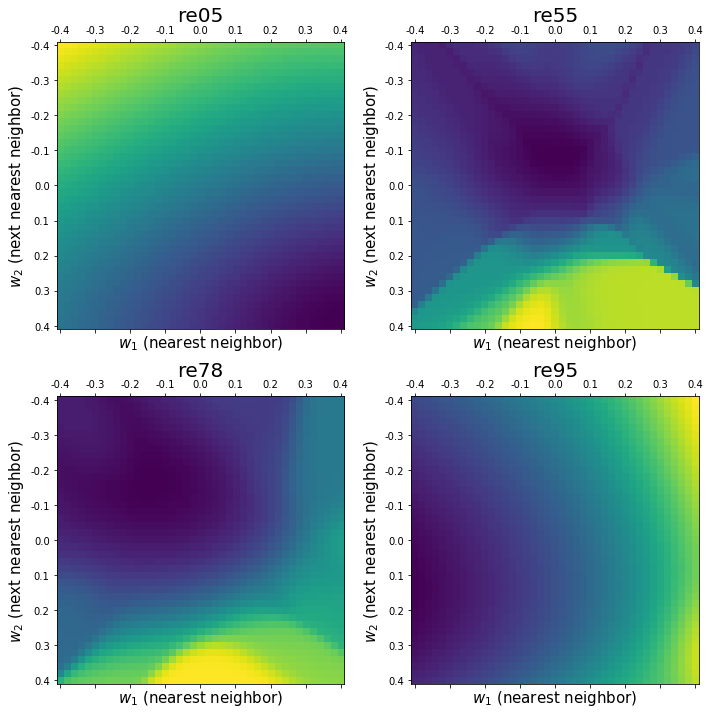

In [27]:
ticklabels = [round(x, 1) for x in np.linspace(-0.5, 0.4, 10)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (key, out_data) in enumerate(s2_profiles.items()):
    ir, ic = divmod(i, 2)
    im = axes[ir, ic].matshow(out_data)
    axes[ir, ic].set_title(key, fontsize=20)
    axes[ir, ic].set_xticklabels(ticklabels)
    axes[ir, ic].set_yticklabels(ticklabels)
    axes[ir, ic].set_xlabel('$w_1$ (nearest neighbor)', fontsize=15)
    axes[ir, ic].set_ylabel('$w_2$ (next nearest neighbor)', fontsize=15)
    indices = np.unravel_index(np.argmin(out_data, axis=None), out_data.shape)

#     print(np.min(out_data), indices)
    print('params', pars_profiles[key][indices])

plt.tight_layout()

### Distance to the combined target data

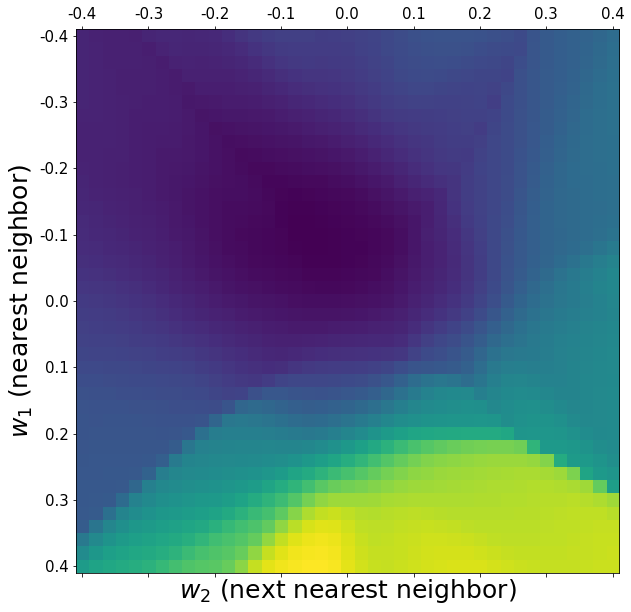

In [32]:
n_tot = sum([n for n in num_samples.values()])
s2_combined = sum([s2_profiles[key]*num_samples[key]/n_tot for key in s2_profiles])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
im = axes.matshow(s2_combined)
indices = np.unravel_index(np.argmin(s2_combined, axis=None), s2_combined.shape)
axes.set_xticklabels(ticklabels, fontsize=15)
axes.set_yticklabels(ticklabels, fontsize=15)
axes.set_xlabel('$w_2$ (next nearest neighbor)', fontsize=25)
axes.set_ylabel('$w_1$ (nearest neighbor)', fontsize=25)
pars_optimal = pars_profiles['re55'][indices]
#axes.set_title('Total\n Optimal parameters: ' + str(pars_optimal), fontsize=20)

### Notes

The profiles for medium concentrations exhibit reasonably well-defined minima close to (0, 0).
The profiles for extreme concentrations are farther from random system (0, 0), but the absolute value of statistical distance is very small and does not influence noticeably the combined distance, which is determined mustly by the medium systems.

In [55]:
pars_all = {
    'optimal': pars_optimal
}

model_hist = {}
for name in names:
    model_hist[name] = average_histogram(pars_optimal, params_list, X_list[name], df_est[name][0], hist_list[name])

In [56]:
model_hist

{'re05': array([8.57654493e-01, 1.15179737e-01, 1.26337073e-03, 2.23278046e-03,
        2.06099091e-03, 1.23678428e-05, 7.85075594e-05, 3.20806739e-05,
        2.82374242e-07, 5.28523101e-07, 4.78706011e-07, 6.37154948e-09,
        0.00000000e+00, 1.93291037e-02, 2.07387271e-03, 1.80604493e-05,
        3.21663030e-05, 2.96836796e-05, 1.68038228e-07, 9.02849659e-07,
        4.05669589e-07, 2.72618015e-09, 3.47558928e-09, 5.38144658e-09,
        5.27900248e-11, 0.00000000e+00]),
 're55': array([0.00069766, 0.00779441, 0.01045698, 0.01801905, 0.01611323,
        0.01155687, 0.07173882, 0.02943643, 0.03081113, 0.0564678 ,
        0.05218569, 0.08194196, 0.01658857, 0.0016483 , 0.02090393,
        0.01986044, 0.03661396, 0.0344402 , 0.01871407, 0.1172519 ,
        0.04952773, 0.04205057, 0.0741569 , 0.07104758, 0.09320993,
        0.0167659 ]),
 're78': array([5.17307511e-07, 1.73057932e-05, 8.77938532e-05, 1.56839614e-04,
        1.44143840e-04, 4.43088993e-04, 2.81020215e-03, 1.16706192e-

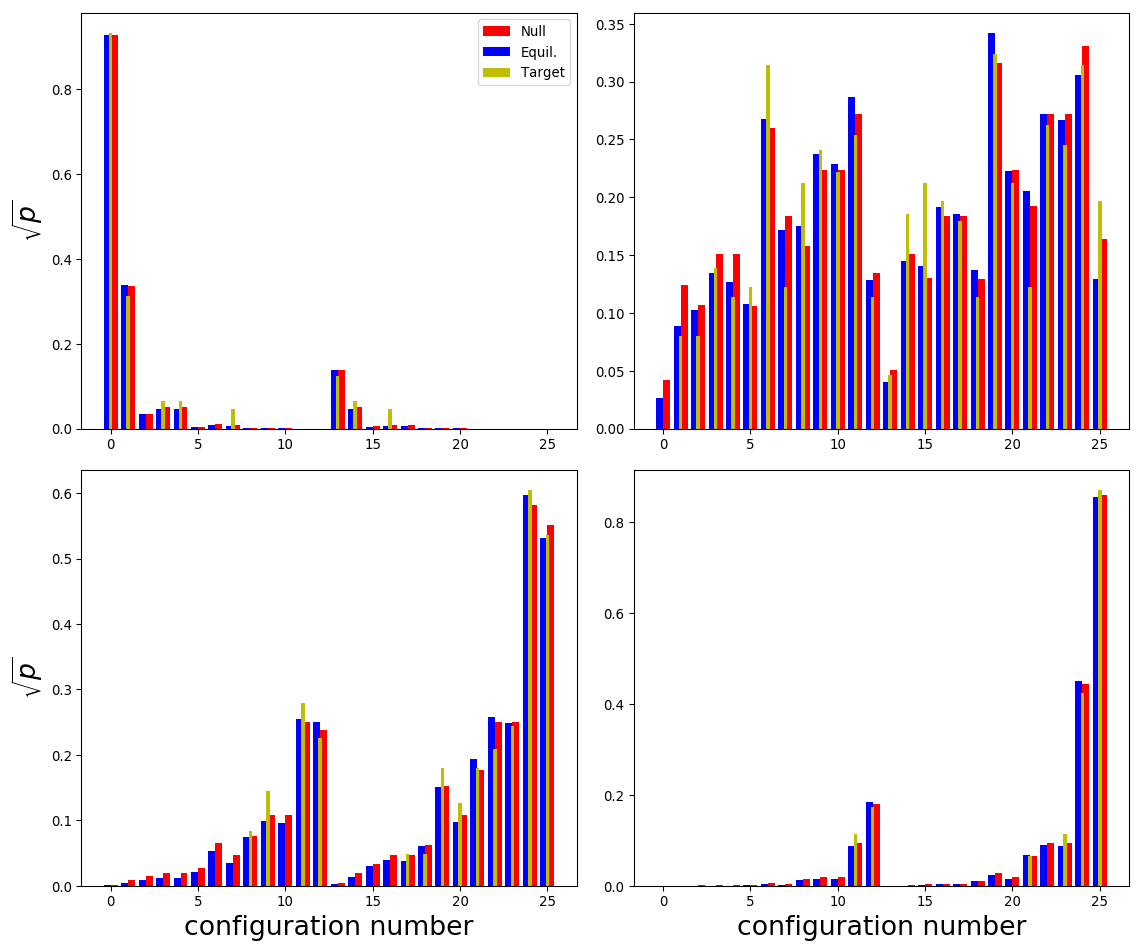

In [65]:
plot_histograms_all(names, num_samples, target_hist, model_hist, prob_conf, cfg_types, x_re)

## 4. Statistical significance analysis

Statistical distance $s$ can be used directly for calculating p-values. It represents the distance between the center of our hypothesis distribution (null or a model), which has a roughly multivariate Gaussian shape in the $\sqrt{p}$ coordinates, and the observed distribution (target histogram). To calculate the p-value, we determine the probability that a sample from our hypothesis distribution is at least as distant as the target sample. This is achieved by integrating the multivariate normal distribution beyond distance $s$, which corresponds to $1 - CDF(\chi^2_k(s))$, where $k$ is the degrees of freedom. For our histogram with 26 bins (local configurations) and one constraint on the sum of probabilities, $k$ is 25.

In [18]:
pars_all = {
    'null': np.array([0.0, 0.0]),
    'optimal': pars_optimal
}

s2_vals = {}
for key, pars_in in pars_all.items():
    s2_vals[key] = {}
    for name in names:
        hist_ave = average_histogram(pars_in, params_list, X_list[name], df_est[name][0], hist_list[name])
        cb1 = np.sqrt(hist_ave).dot(np.sqrt(hist_targ[name]))
        s2_vals[key][name] = np.arccos(cb1)**2

### Null hypothesis - random distribution (zero interactions)

In [19]:
print('Null')
print('Parameters:', *pars_all['null'], '\n')

s2_tot = 0.0
n_tot = 0
for name in names:
    n = num_samples[name]
    n_tot += n
    s2 = s2_vals['null'][name]
    s2_tot += n*s2
    print('System:', name)
    print('Number of samples:', n)
    print('Statistical distance:', s2)
    print('p-value:', 1-chi2.cdf(n*4*s2, 25))
    print('')

s2_tot /= n_tot
    
print('System: Combined')
print('Number of samples:', n_tot)
print('Statistical distance:', s2_tot)
print('p-value:', 1-chi2.cdf(n_tot*4*s2_tot, 100))
print('')

Null
Parameters: 0.0 0.0 

System: re05
Number of samples: 464
Statistical distance: 0.006212278317073199
p-value: 0.9899613914803115

System: re55
Number of samples: 466
Statistical distance: 0.032477904994081874
p-value: 8.808820454608846e-05

System: re78
Number of samples: 434
Statistical distance: 0.029777885179878782
p-value: 0.0013102025604574408

System: re95
Number of samples: 471
Statistical distance: 0.012365896789153548
p-value: 0.5602047990677097

System: Combined
Number of samples: 1835
Statistical distance: 0.02003549886764187
p-value: 0.0015389971792818535



### Best model

In [20]:
print('Optimized')
print('Parameters:', *pars_all['optimal'], '\n')

s2_tot = 0.0
n_tot = 0
for name in names:
    n = num_samples[name]
    n_tot += n
    s2 = s2_vals['optimal'][name]
    s2_tot += n*s2
    print('System:', name)
    print('Number of samples:', n)
    print('Statistical distance:', s2)
    print('p-value:', 1-chi2.cdf(n*4*s2, 25))
    print('')

s2_tot /= n_tot
    
print('System: Combined')
print('Number of samples:', n_tot)
print('Statistical distance:', s2_tot)
print('p-value:', 1-chi2.cdf(n_tot*4*s2_tot, 100))
print('')

Optimized
Parameters: -0.1 -0.06 

System: re05
Number of samples: 464
Statistical distance: 0.006977868409899716
p-value: 0.9770971070437284

System: re55
Number of samples: 466
Statistical distance: 0.0287612155557316
p-value: 0.0007461207652499358

System: re78
Number of samples: 434
Statistical distance: 0.024721759100343854
p-value: 0.01429314281015226

System: re95
Number of samples: 471
Statistical distance: 0.012138474462616275
p-value: 0.585219462130665

System: Combined
Number of samples: 1835
Statistical distance: 0.018031020333845172
p-value: 0.016800871689568342



## 5. Conclusions

The random model (null hypothesis) is in a decent agreement with the configuration statistics for extreme Re concentrations, but it would not pass the standard significance of 0.05 or 0.01 for the extremes. Also, it would not pass for the combined set of target images.

The optimized model, whose parameters suggest slight Re-Mo attraction, improves the match for the medium Re concentrations. Although it misses the test for re55 system, it would pass the 0.01 level for the other systems and the combined data set. 

### Some additional thoughts

Assuming that the patterns originate from particle interactions, it seems a bit odd that the Mo-Re interaction would be attractive. A closer look at the images suggests that the like pairs (Mo-Mo & Re-Re) prefer formation of blocks (diamond-shaped group of 4 atoms of the same type) or lines (atom pairs). However there is a good chance that this block may be surrounded by the other element and, as a result, the average interaction may seem attractive for Mo-Re.

The patterns seen in the images look anisotropic, which our model does not reproduce. If there is a preferred number of neighbors of each type, including manybody interactions using simple bond valence terms may potentially improve description for medium concentrations but also for extreme concentrations that seem to suggest attractions between like atoms. (This may be stretching the noisy data too far).

## Phase diagrams

In [66]:
files = ['re05', 're13', 're30', 're38', 're50', 're55', 're78', 're95']

In [142]:
data = []
for fname in files:
    data.append(np.loadtxt(os.path.join(sim_dir, 'dat_' + fname)))

In [143]:
conc = lambda x: x[0,0]
dsort = sorted(data, key=conc)
dsort += dsort[-2::-1]

In [155]:
x = np.array([d[0,0] if i < len(dsort)//2 else 1-d[0,0] for i, d in enumerate(dsort)])
y = data[0][:,1]
G = np.array([d[:,2] for d in dsort]).T
S = np.array([d[:,4] for d in dsort]).T
U = np.array([d[:,3] for d in dsort]).T


X, Y = np.meshgrid(x, y)

print('shapes', x.shape, y.shape, X.shape, Y.shape, G.shape, S.shape)

shapes (15,) (101,) (101, 15) (101, 15) (101, 15) (101, 15)


In [156]:
x

array([0.02148438, 0.04248047, 0.12988281, 0.15673828, 0.29980469,
       0.37988281, 0.40380859, 0.5       , 0.59619141, 0.62011719,
       0.70019531, 0.84326172, 0.87011719, 0.95751953, 0.97851562])

In [172]:
from matplotlib.font_manager import *

def plot_tdm(X, Y, D):

    fig = plt.figure(1, figsize =(9.0, 6.0), dpi=600)

    ylab = r'$\beta=1/k_BT$'
    plt.ylabel(ylab, fontsize=24.0)
    xlab = r'$x$'
    plt.xlabel(xlab, fontsize=24.0)

    origin = 'lower'
    
    dmax = np.max(D)
    dmin = np.min(D)
    dd = (dmax - dmin)/26
    levels = [dmin + float(i)*dd for i in range(26)]
    CS3 = plt.contourf(X, Y, D, levels, cmap=plt.cm.summer, origin=origin, extend='both')
    CS3.cmap.set_bad(color='k')
    CS3.cmap.set_under(color='k')
    CS3.cmap.set_over(color='w')
    
    CS4 = plt.contour(X, Y, D, levels, colors = ('r',), linewidths = (0.5,), origin = origin)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

#     xmin = dmin
#     ymin = dmax
#     plot([xmin], [ymin],'w+', markersize=12, mec='white', mew=2.0)

    cbar = plt.colorbar(CS3)
    cbar.ax.tick_params(labelsize=15)
    
#    plt.axis([0.0, 1.98, 0.0, 1.0])
#     fs = 20
#     ax = gca()
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label1.set_fontsize(fs)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label1.set_fontsize(fs)

#     gcf().subplots_adjust(bottom=0.13, right=0.75)

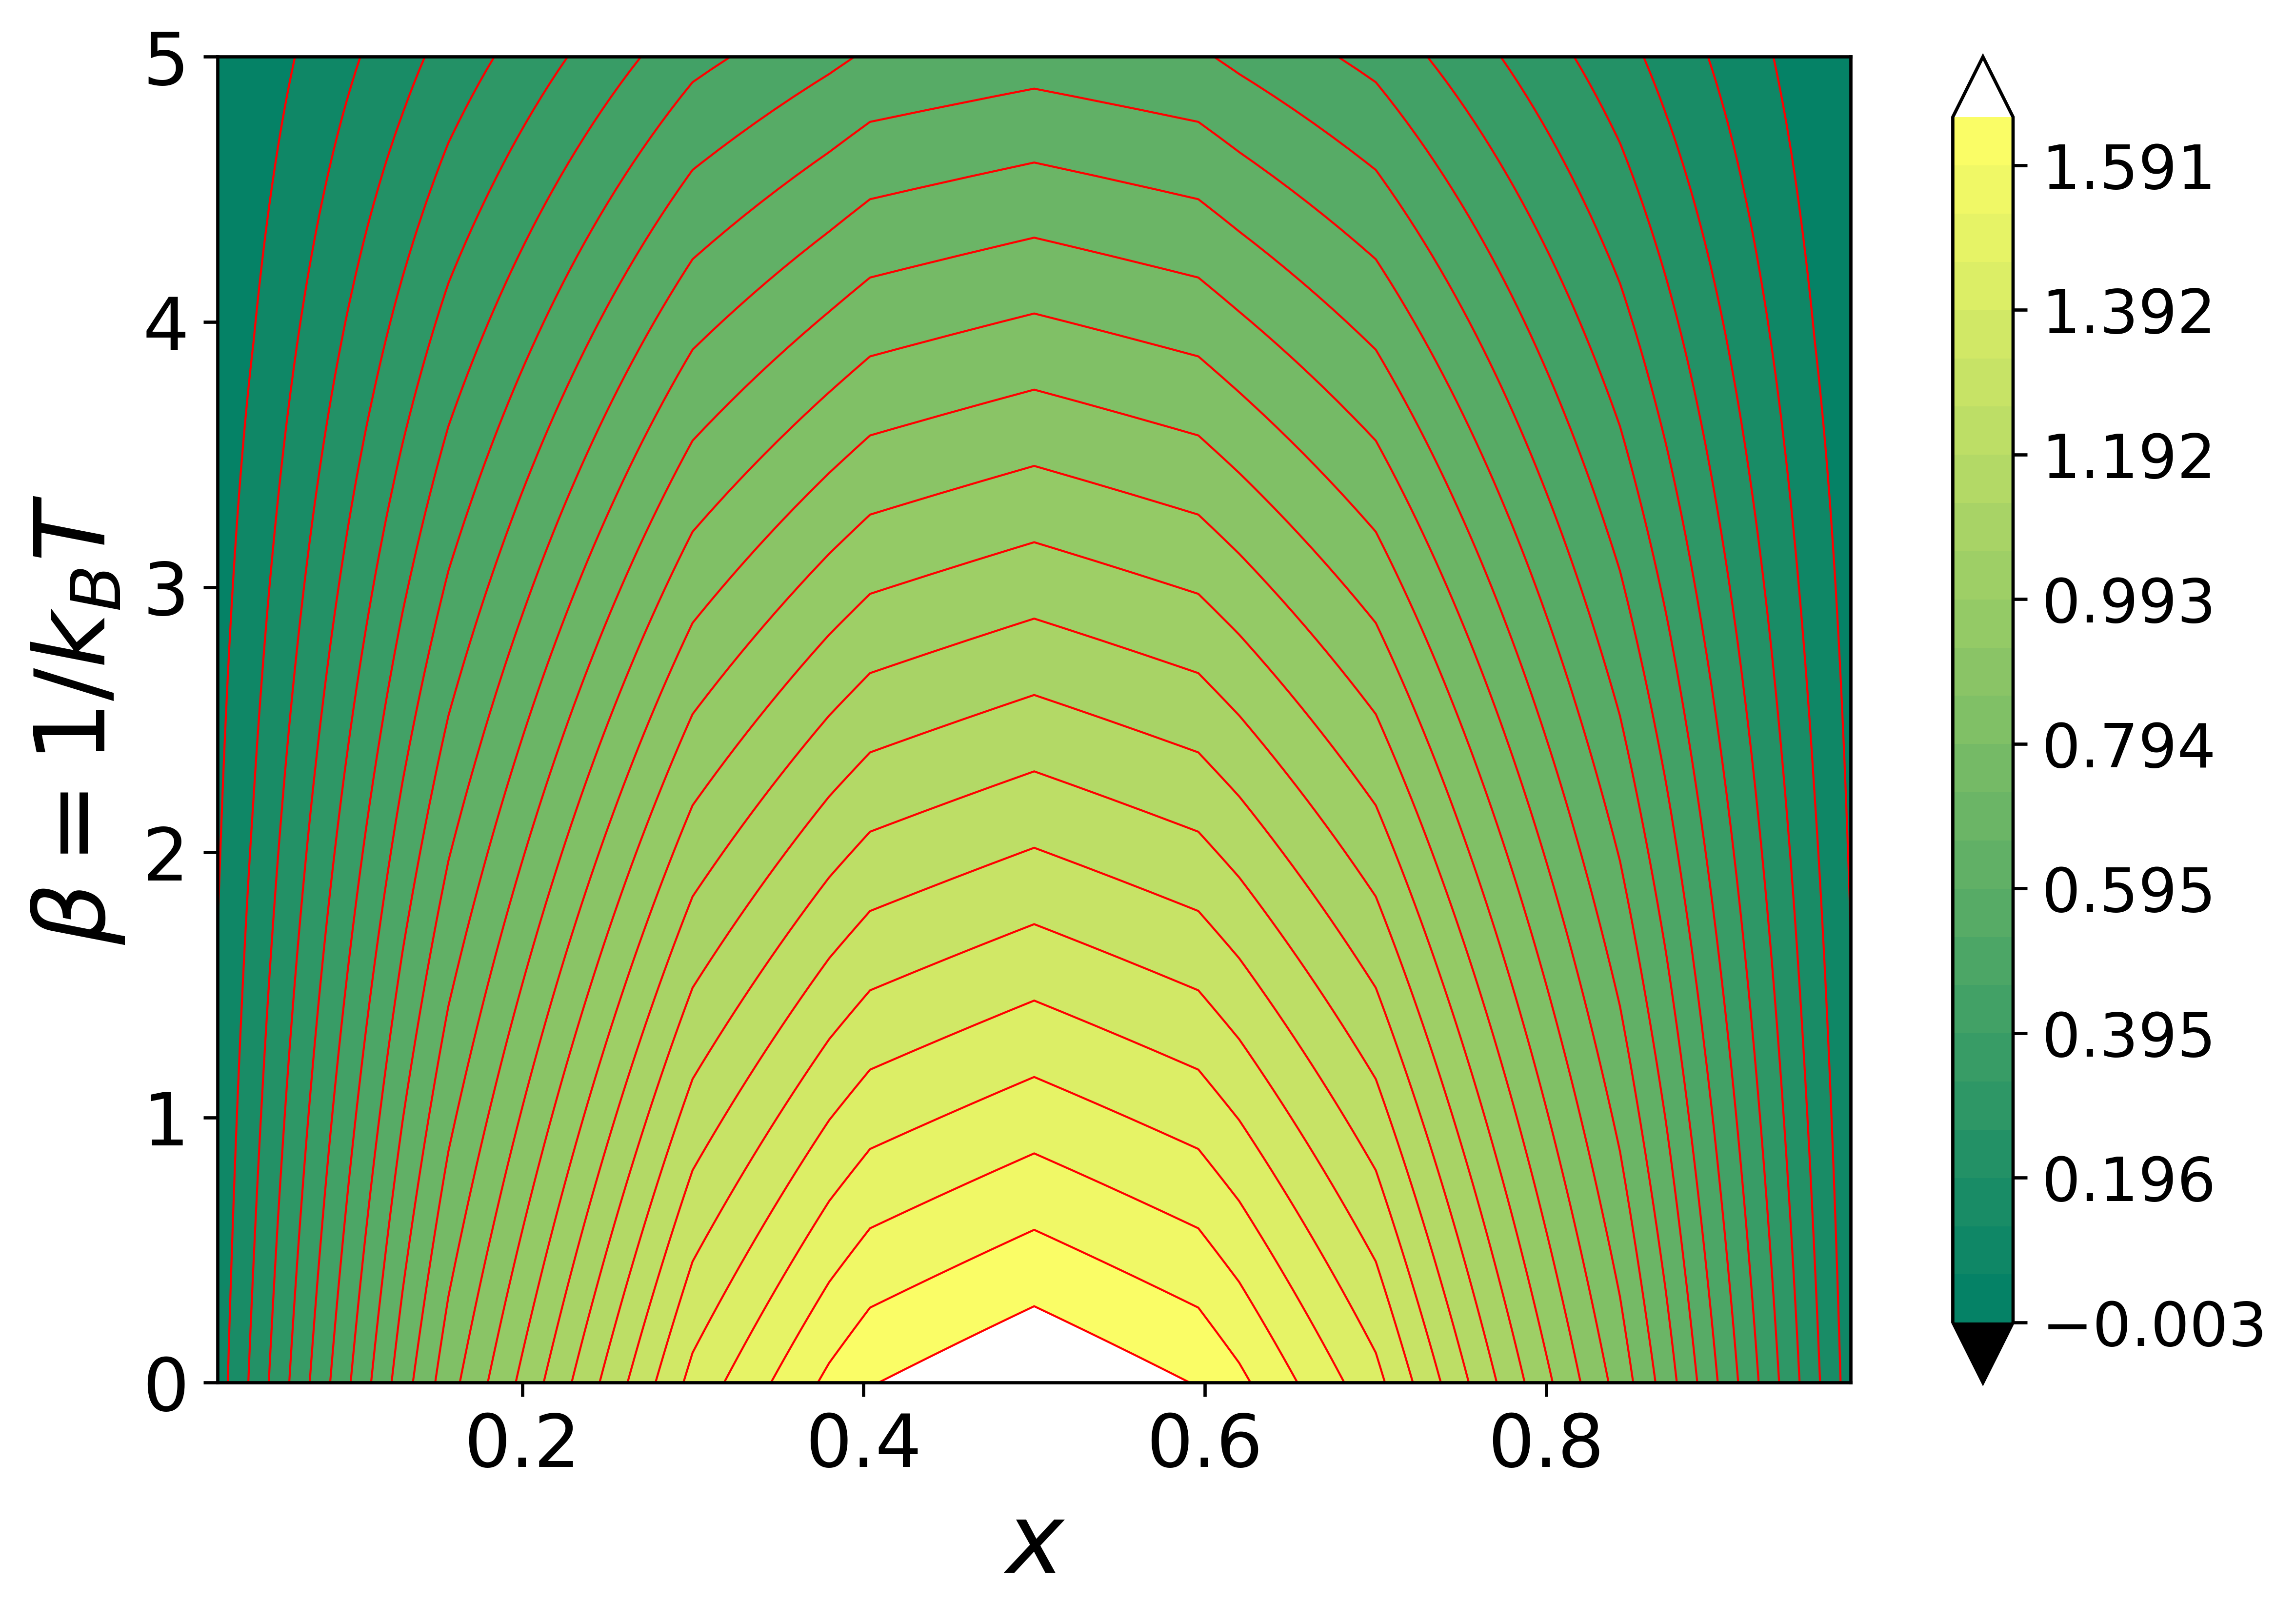

In [173]:
plot_tdm(X, Y, G)

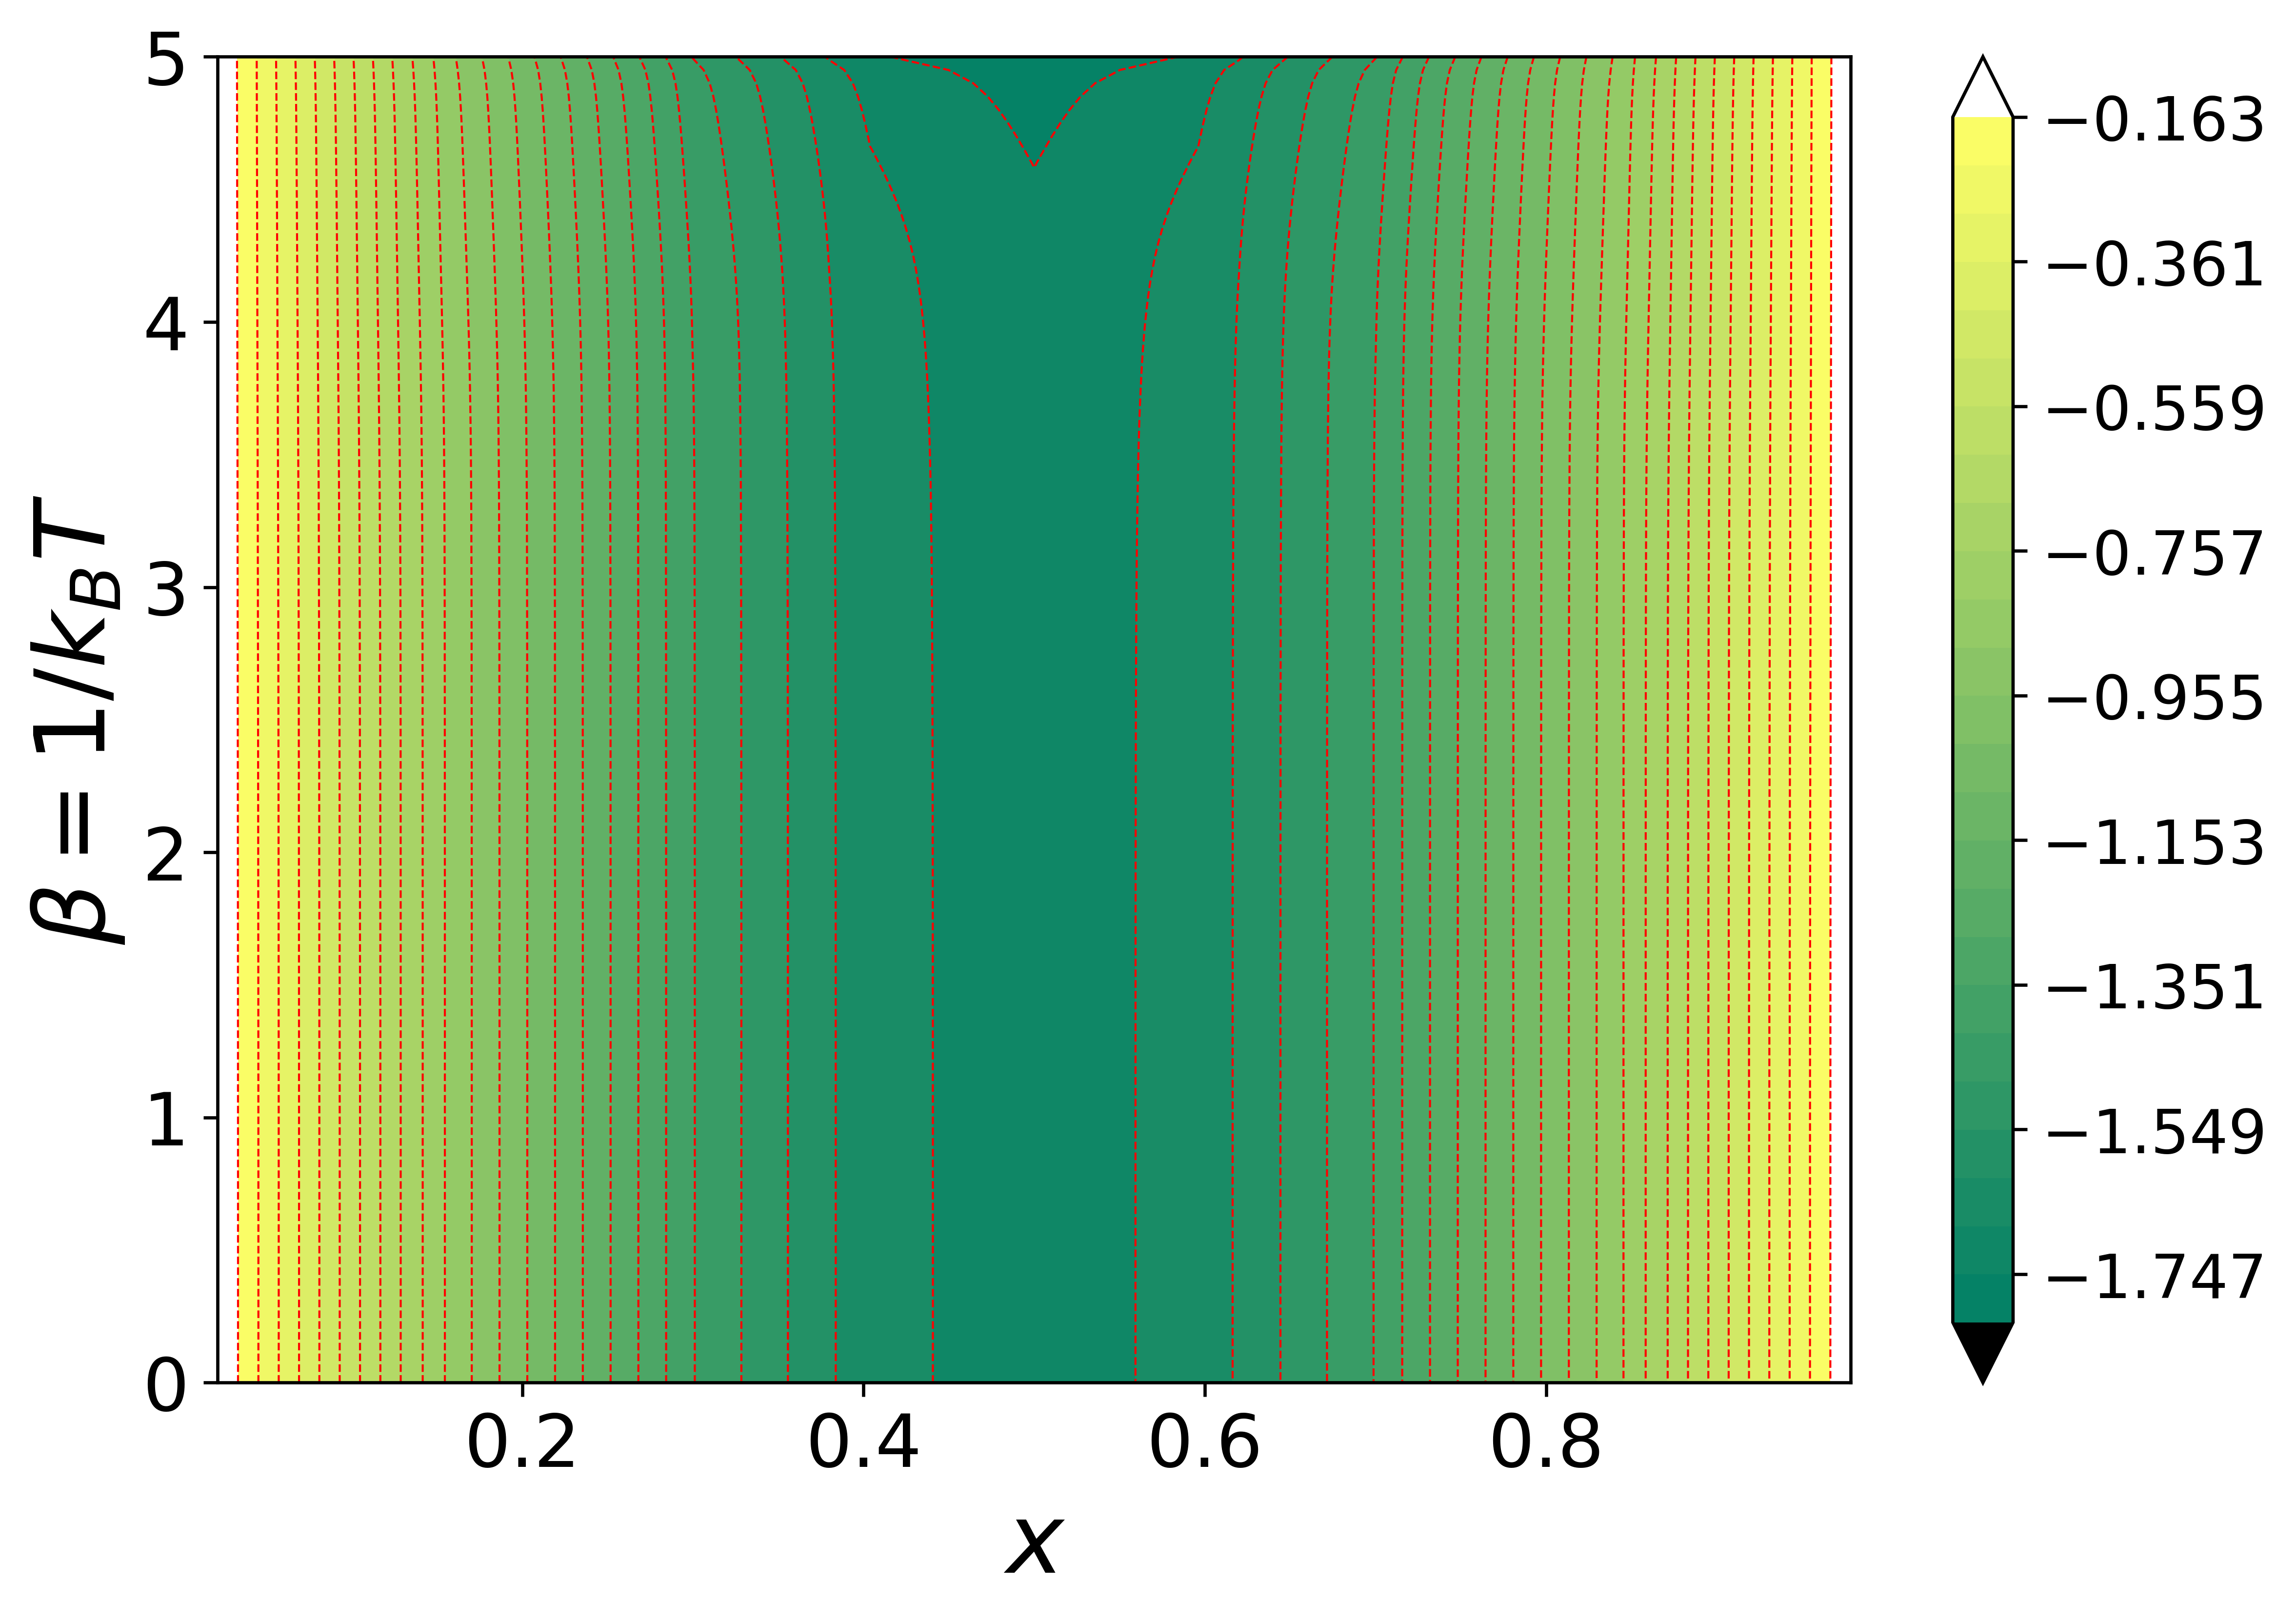

In [174]:
plot_tdm(X, Y, S)